In [1]:
#import the picture
import cv2
import numpy as np

import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import pandas as pd

In [2]:

# Specify the file path of the image
image_path = "input_trial.jpg"


# Read the image
image_input = cv2.imread(image_path)

# Check if the image was successfully read
if image_input is not None:
    # Image was read successfully
    print("Image read successfully!")
else:
    # Failed to read the image
    print("Failed to read the image.")

Image read successfully!


In [10]:
# import reference points
image_data_path = "input_trial.dat"
with open(image_data_path,"r") as f:
    reference_points = f.readlines()
    reference_points = [x.strip() for x in reference_points]
ds=np.array([ float(x) for x in reference_points[3:6]])
ps=np.array([ [float(y) for y in x.split()] for x in reference_points[0:3]])
h,w,_=image_input.shape
print(  f'{w=}, {h=}')
ps0=np.array([[(w-1)*0.5,(h-1)*0.5]]*3)
c: float=int(reference_points[6])*w/36.0
ds,ps,ps0,c

w=5792, h=4344


(array([0.155, 0.311, 0.27 ]),
 array([[2381., 4245.],
        [1355., 2855.],
        [4565., 2355.]]),
 array([[2895.5, 2171.5],
        [2895.5, 2171.5],
        [2895.5, 2171.5]]),
 4344.0)

In [11]:
# copy image_input
image = image_input.copy()

# write 3 circles at ps on the image
for i in range(3):
    image = cv2.circle(image, (int(ps[i][0]), int(ps[i][1])), 25, (0, 0, 255), -1)

#write a line between the each pair of points
for i in range(3):
    image = cv2.line(image, (int(ps[i][0]), int(ps[i][1])), (int(ps[(i+1)%3][0]), int(ps[(i+1)%3][1])), (0, 0, 255), 5)

# write the distance (ds) between the points belong the line above
for i in range(3):
    image = cv2.putText(image, str(ds[i]), (int((ps[i][0]+ps[(i+1)%3][0])/2), int((ps[i][1]+ps[(i+1)%3][1])/2)), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)

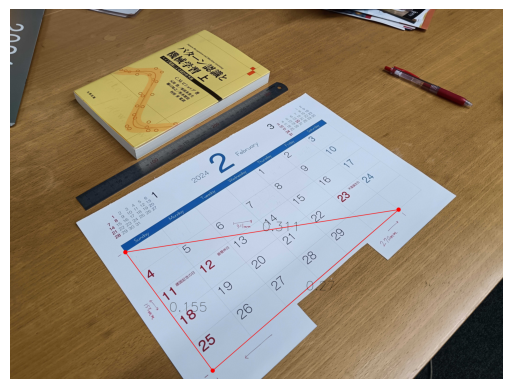

In [12]:
#save the image
cv2.imwrite('output.jpg', image)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [13]:
# Define a RotationMatrix class
# It includes the following attributes:
# -  3 angles defining the rotation matrix. (kappa, phi, omega)
# return the li,mi,ni (i=0,1,2) for te given angles
# 
class RotationMatrix:
    def __init__(self, omega: float, phi: float, kappa: float):
        self.kappa :float = kappa
        self.phi :float = phi
        self.omega :float = omega
        self.li = np.array([np.cos(phi)*np.cos(kappa), np.cos(phi)*np.sin(kappa), -np.sin(phi)])

        self.mi = np.array([np.sin(omega)*np.sin(phi)*np.cos(kappa)-np.cos(omega)*np.sin(kappa), np.sin(omega)*np.sin(phi)*np.sin(kappa)+np.cos(omega)*np.cos(kappa), np.sin(omega)*np.cos(phi)])
        
        self.ni = np.array([np.cos(omega)*np.sin(phi)*np.cos(kappa)+np.sin(omega)*np.sin(kappa), np.cos(omega)*np.sin(phi)*np.sin(kappa)-np.sin(omega)*np.cos(kappa), np.cos(omega)*np.cos(phi)])
        
        # The partial derivatives of the rotation matrix
        # Copilot Generated this code, however, I t was not mathematically correct
        # I had to correct it
        self.li_kappa = np.array([-np.cos(phi)*np.sin(kappa), np.cos(phi)*np.cos(kappa), 0])
        self.li_phi = np.array([-np.sin(phi)*np.cos(kappa), -np.sin(phi)*np.sin(kappa), -np.cos(phi)])
        self.li_omega = np.array([0, 0, 0])
        
        self.mi_kappa = np.array([-np.sin(omega)*np.sin(phi)*np.sin(kappa)-np.cos(omega)*np.cos(kappa), np.sin(omega)*np.sin(phi)*np.cos(kappa)-np.cos(omega)*np.sin(kappa), 0.0])
        self.mi_phi = np.array([np.sin(omega)*np.cos(phi)*np.cos(kappa), np.sin(omega)*np.cos(phi)*np.sin(kappa), -np.sin(omega)*np.sin(phi)])
        self.mi_omega = np.array([np.cos(omega)*np.cos(phi)*np.cos(kappa)+np.sin(omega)*np.sin(kappa), np.cos(omega)*np.sin(phi)*np.sin(kappa)-np.sin(omega)*np.cos(kappa), np.cos(omega)*np.cos(phi)])
        
        self.ni_kappa = np.array([-np.cos(omega)*np.sin(phi)*np.sin(kappa)+np.sin(omega)*np.cos(kappa), np.cos(omega)*np.sin(phi)*np.cos(kappa)+np.sin(omega)*np.sin(kappa), 0.0])
        self.ni_phi = np.array([np.cos(omega)*np.cos(phi)*np.cos(kappa), np.cos(omega)*np.cos(phi)*np.sin(kappa), -np.cos(omega)*np.sin(phi)])
        self.ni_omega = np.array([-np.sin(omega)*np.sin(phi)*np.cos(kappa)+np.cos(omega)*np.sin(kappa), -np.sin(omega)*np.sin(phi)*np.sin(kappa)-np.cos(omega)*np.cos(kappa), -np.sin(omega)*np.cos(phi)])
        
        # Rotation Matrix
        self.matrix = np.array([self.li, self.mi, self.ni])
        self.matrix_omega = np.array([self.li_omega, self.mi_omega, self.ni_omega])
        self.matrix_phi = np.array([self.li_phi, self.mi_phi, self.ni_phi])
        self.matrix_kappa = np.array([self.li_kappa, self.mi_kappa, self.ni_kappa])

        
    def __str__(self):
        return f'omega={self.omega}, phi={self.phi}, kappa={self.kappa}\nMatrix={self.matrix}'

# Define a DistanceConstraint class
# It includes the following attributes:
# -  2 points \in R3 defining the distance constraint. (p1, p2)
# -  The distance between the 2 points. (d)
# return the partial derivatives of the distance constraint
#
class DistanceConstraint:
    def __init__(self, X1: np.array, X2: np.array, d: float):
        self.X1 = X1
        self.X2 = X2
        self.dX = X1-X2
        self.d = d
        self.error = self.dX[0]**2 + self.dX[1]**2 - d**2
        self.derror_dxy = np.array([[2*self.dX[0], -2*self.dX[0]],[2*self.dX[1], -2*self.dX[1]]])# [de/dx1, de/dx2], [de/dy1, de/dy2]
        
    def __str__(self):
        return f'error={self.error}'

# Define a ColinearityConstraint class
# It includes the following attributes:
# -  RotationMatrix object
# -  focal length (c)
# -  a pair of points \in R2  on the image and the corresponding 3d points \in R3. (p, X)
# return the partial derivatives of the colinearity constraint
#
class ColinearityConstraint:
    def __init__(self, rotation_matrix: RotationMatrix, c:float , p: np.array, X: np.array):
        self.rotation_matrix = rotation_matrix
        self.p = p
        self.X = X
        self.li = rotation_matrix.li
        self.mi = rotation_matrix.mi
        self.ni = rotation_matrix.ni
        self.c= c
        self.inv_c = 1/c
        self.errorXY =np.array([np.dot(rotation_matrix.matrix[:,0], X) - p[0]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X),
                                 np.dot(rotation_matrix.matrix[:,1], X) - p[1]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X)]) # [eX, eY]
        self.derrorXY_dxyz = np.array([[ self.rotation_matrix.matrix[i,0] - p[0]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)],# [deX/dX, deX/dY, deX/dZ]
                                      [ self.rotation_matrix.matrix[i,1] - p[1]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)]])# [deY/dX, deY/dY, deY/dZ]
        # [deX/domega, deY/domega]
        self.derrorXY_domega = np.array([np.dot(self.rotation_matrix.matrix_omega[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_omega[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_omega[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_omega[:,2],X)])
        # [deX/dphi, deY/dphi]
        self.derrorXY_dphi = np.array([np.dot(self.rotation_matrix.matrix_phi[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_phi[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_phi[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_phi[:,2],X)])
        # [deX/dkappa, deY/dkappa]
        self.derrorXY_dkappa = np.array([np.dot(self.rotation_matrix.matrix_kappa[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_kappa[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_kappa[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_kappa[:,2],X)])

    def __str__(self):
        return f'errorX={self.errorXY[0]}\n\terrorY={self.errorXY[1]}'


In [14]:
initialize=lambda x1, y1,y2,x3,y3,h,omega,phi,kappa: (np.array([[x1,y1,h],[x1,y2,h],[x3,y3,h]]), omega,phi,kappa)

In [15]:
#generate random variables for the 3d points
Xs,omega,phi,kappa=initialize(random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],random.random()*ds[0],
                              random.random()*ds[0],-0.5,0,0,0)
#generate random variables for the 3d points
d_base=np.abs(random.random()*ds[0])
Xs,omega,phi,kappa=initialize(d_base,d_base,
                              d_base*1.5,d_base*1.5,
                              d_base*2,-0.5,0,0,0)

In [16]:
Xs,_,_,_=initialize(0.2,0.3,0.4,0.5,0.2,-0.5,0,0,0)
d_base=np.abs(random.random()*ds[0])
Xs,_,_,_=initialize(d_base,d_base,
                              d_base*1.5,d_base*1.5,
                              d_base*2,-0.5,0,0,0)


In [17]:
max_iter=100
b_collect=np.zeros((9,max_iter))
angle_collect=np.zeros((3,max_iter))
Xs_collect=np.zeros((3,3,max_iter))
det_collect=np.zeros((max_iter))

print(Xs,omega,phi,kappa)
for iter in range(max_iter):
    if Xs[0,2]>0:
        Xs=-Xs
    if Xs[1,1]-Xs[0,1]<0:
        Xs[:,0:2]=-Xs[:,0:2]
    while phi>np.pi:
        phi-=2*np.pi
    while phi< -np.pi:
        phi+=2*np.pi
    if phi<0:
        phi=-phi
        omega+=np.pi
        kappa+=np.pi
    while omega>np.pi:
        omega-=2*np.pi
    while omega< -np.pi:
        omega+=2*np.pi
    while kappa>np.pi:
        kappa-=2*np.pi
    while kappa< -np.pi:
        kappa+=2*np.pi
    R=RotationMatrix(omega,phi,kappa)
    distance_constraint=[DistanceConstraint(Xs[i%3],Xs[(i+1)%3],ds[i]) for i in range(3)]
    #colinearity_constraint=[ColinearityConstraint(R,c,ps[i]-ps0[i],Xs[i,:]) for i in range(3)]
    colinearity_constraint=[ColinearityConstraint(R,c,ps0[i]-ps[i],Xs[i,:]) for i in range(3)]
    

    A=np.zeros((9,9))
    b=np.zeros(9)

    indeces=[(0,1,5),(0,2,5),(3,4,5)]
    #attributing the partial derivatives to the matrix A and the error to the vector b
    #distance constraints
    for i in range(3):
        inv_d=1/distance_constraint[i].d
        for j in range(2):
            A[i,indeces[(i+j)%3][0]]+=distance_constraint[i].derror_dxy[0,j]*inv_d
            A[i,indeces[(i+j)%3][1]]+=distance_constraint[i].derror_dxy[1,j]*inv_d
        b[i]= - distance_constraint[i].error*inv_d
    
    # colinearity constraints
    for i in range(3):
        for j in range(2):
            A[3+2*i+j,indeces[i]] = colinearity_constraint[i].derrorXY_dxyz[j,0:3]
            A[3+2*i+j,6:9] = (colinearity_constraint[i].derrorXY_domega[j],colinearity_constraint[i].derrorXY_dphi[j],colinearity_constraint[i].derrorXY_dkappa[j])
            b[3+2*i+j] = - colinearity_constraint[i].errorXY[j]
    b_collect[:,iter]=b
    angle_collect[:,iter]=omega,phi,kappa
    det_collect[iter]= np.linalg.det(A)
    Xs_collect[:,:,iter]=Xs


    dx=np.linalg.solve(A,b)
    alpha=0.1
    for i in range(3):
        Xs[i]+=dx[indeces[i],]*alpha
    

    omega+=dx[6]*alpha
    phi+=dx[7]  *alpha
    kappa+=dx[8]*alpha
    if iter%1==0:
        print(f'iteration {iter}')
        for i in range(3):
            print("\t",distance_constraint[i])
        for i in range(3):
            print("\t",colinearity_constraint[i])
        print("\t",Xs,omega,phi,kappa)



[[ 0.10393902  0.10393902 -0.5       ]
 [ 0.10393902  0.15590853 -0.5       ]
 [ 0.15590853  0.20787804 -0.5       ]] 0 0 0
iteration 0
	 error=-0.02132417006641946
	 error=-0.09131934013283892
	 error=-0.0593958503320973
	 errorX=0.1631586325658086
	errorY=-0.13472350371411773
	 errorX=0.2812525552177423
	errorY=0.07723679783582156
	 errorX=-0.036253073250734624
	errorY=0.18675695205611076
	 [[37.8181271  -7.08938989  6.60663843]
 [37.8181271  -7.01690434  6.60663843]
 [38.02970093 -7.03668058  6.60663843]] 12.663015618246835 76.66862233870258 6.336481885552789
iteration 1
	 error=-0.018770845190525905
	 error=-0.05156641281454977
	 error=-0.02535824141934078
	 errorX=9.124492727497845
	errorY=-24.451549523812936
	 errorX=18.166155798917984
	errorY=-12.132233992029686
	 errorX=-10.13015054440325
	errorY=-7.7522033712492595
	 [[ 28.09112641 -46.16775228  20.77970293]
 [ 28.09112641 -46.08231874  20.77970293]
 [ 28.31231675 -46.12958858  20.77970293]] 5.576158779828289 1.725392072283905

In [18]:
with open('output.dat','a') as f:
    f.write(f'{Xs[0,0]:0.4f}, {Xs[0,1]:0.4f}, {Xs[1,1]:0.4f}, {Xs[2,0]:0.4f}, {Xs[2,1]:0.4f}, {Xs[0,2]:0.4f}\n')
    f.write(f'{omega:0.4f}, {phi:0.4f}, {kappa:0.4f}\n')
    f.write(', '.join([f'{b_collect[i,-1]:0.4f}'for i in range(9)])+'\n')
    

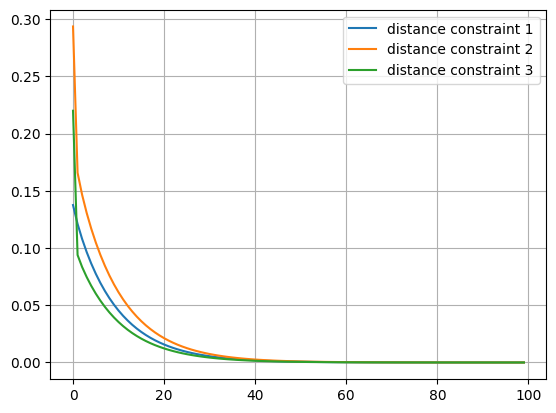

In [19]:
#Illustrate the evolution of the error
plt.plot(b_collect[0,:],label='distance constraint 1')
plt.plot(b_collect[1,:],label='distance constraint 2')
plt.plot(b_collect[2,:],label='distance constraint 3')

plt.grid()
plt.legend()
plt.show()

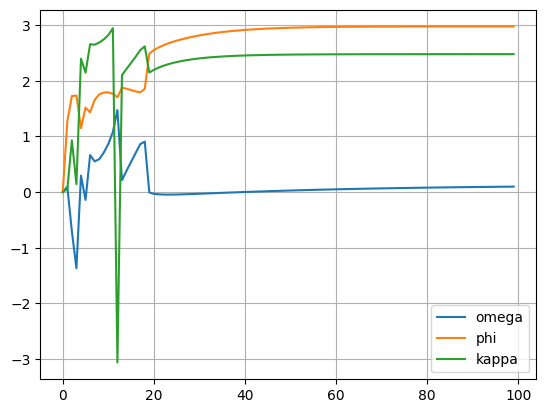

In [20]:
#Illustrate the evolution of the angles
plt.plot(angle_collect[0,:],label='omega')
plt.plot(angle_collect[1,:],label='phi')
plt.plot(angle_collect[2,:],label='kappa')

plt.grid()
plt.legend()
plt.show()


In [21]:
Xs_collect[:,:,-1]

array([[-0.08111172, -0.07635405, -0.02156997],
       [-0.08111172,  0.07864405, -0.02156997],
       [ 0.18888599, -0.07569531, -0.02156997]])

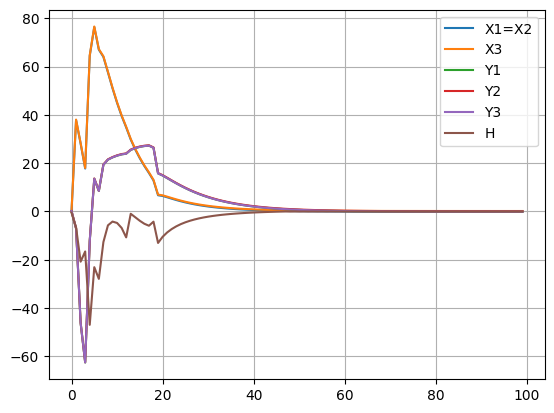

array([[-0.08111172, -0.07635405, -0.02156997],
       [-0.08111172,  0.07864405, -0.02156997],
       [ 0.18888599, -0.07569531, -0.02156997]])

In [22]:
#Illustrate the evolution of the Xs
plt.plot(Xs_collect[0,0,:],label='X1=X2')
plt.plot(Xs_collect[2,0,:],label='X3')
plt.plot(Xs_collect[0,1,:],label='Y1')
plt.plot(Xs_collect[1,1,:],label='Y2')
plt.plot(Xs_collect[2,1,:],label='Y3')
plt.plot(Xs_collect[0,2,:],label='H')

plt.grid()
plt.legend()

plt.show()
Xs_collect[:,:,-1]

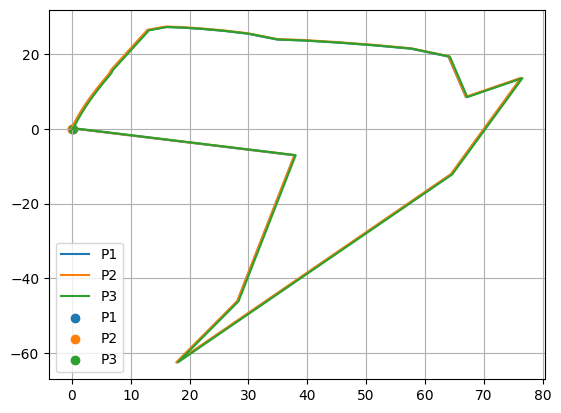

array([[-0.08111172, -0.07635405, -0.02156997],
       [-0.08111172,  0.07864405, -0.02156997],
       [ 0.18888599, -0.07569531, -0.02156997]])

In [23]:
#Illustrate the evolution of the Xs onxy plane
plt.plot(Xs_collect[0,0,:],Xs_collect[0,1,:],label='P1')
plt.plot(Xs_collect[1,0,:],Xs_collect[1,1,:],label='P2')
plt.plot(Xs_collect[2,0,:],Xs_collect[2,1,:],label='P3')

plt.scatter(Xs_collect[0,0,-1],Xs_collect[0,1,-1],label='P1')
plt.scatter(Xs_collect[1,0,-1],Xs_collect[1,1,-1],label='P2')
plt.scatter(Xs_collect[2,0,-1],Xs_collect[2,1,-1],label='P3')

plt.grid()
plt.legend()
plt.show()
Xs_collect[:,:,-1]

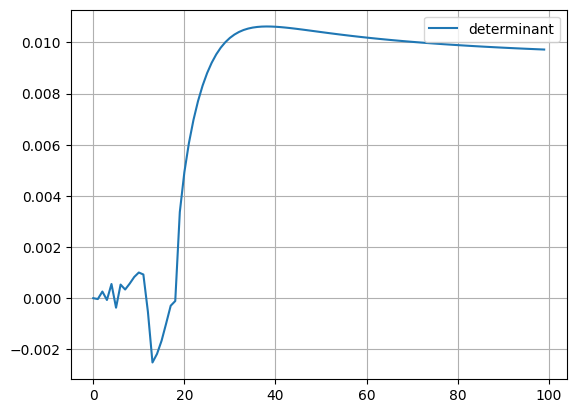

In [24]:
#Illustrate the evolution of the determinant
plt.plot(det_collect,label='determinant')
plt.grid()
plt.legend()
plt.show()


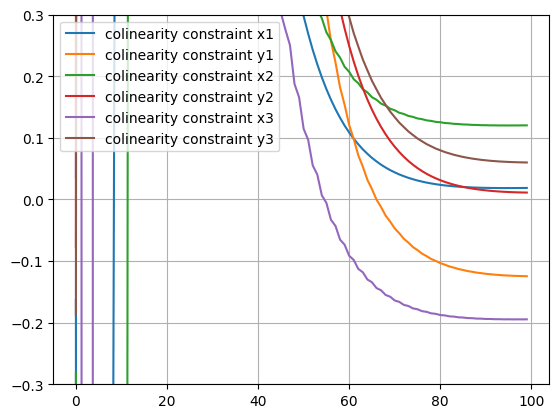

In [25]:
#Illustrate the evolution of the error of constraint
plt.plot(b_collect[3,:],label='colinearity constraint x1')
plt.plot(b_collect[4,:],label='colinearity constraint y1')
plt.plot(b_collect[5,:],label='colinearity constraint x2')
plt.plot(b_collect[6,:],label='colinearity constraint y2')
plt.plot(b_collect[7,:],label='colinearity constraint x3')
plt.plot(b_collect[8,:],label='colinearity constraint y3')
plt.ylim(-0.3,0.3)
plt.grid()
plt.legend()
plt.show()


In [26]:
for i in range(3):
    print(distance_constraint[i])
for i in range(3):
    print(colinearity_constraint[i])

error=-5.890512482648047e-07
error=-1.5995257393180973e-06
error=-8.035129708261479e-07
errorX=-0.0187241171265306
	errorY=0.12454352683998321
errorX=-0.12030867646169406
	errorY=-0.011213480083528703
errorX=0.19455855568808386
	errorY=-0.06006304416854292


In [36]:
num_cases_max=300
num_cases=50
b_collect=np.zeros((9,num_cases))
angle_collect=np.zeros((3,num_cases))
Xs_collect=np.zeros((3,3,num_cases))
dXs_collect=np.zeros((9,num_cases))
det_collect=np.zeros((num_cases))

case_count=0

for i_case in range(num_cases_max):
    if case_count>=num_cases:
        break
    print(f'case {i_case}')
    # initialize with random values
    # generate random variables for the 3d points
    d_base=np.abs(random.random()*ds[0])+0.05
    Xs,omega,phi,kappa=initialize(d_base,d_base,
                                d_base*1.5,d_base*1.5,
                                d_base*2,-0.5,0,0,0)
    # ### initialize with an appropriate value
    # Xs,omega,phi,kappa=initialize(0.035,0.09,
    #                             0.25,0.31,
    #                             0.094,-0.33,5.7,3.6,2.6)
    # ### initialize with another value
    # Xs,omega,phi,kappa=initialize(-0.010, -0.29,
    #                             -0.13, 0.26, 
    #                             -0.29, -0.26, 0.54, 3.5, 2.5)
                                                        

    max_iter=1000

    #print(Xs,omega,phi,kappa)
    for iter in range(max_iter):
        
        while phi>np.pi:
            phi-=2*np.pi
        while phi< -np.pi:
            phi+=2*np.pi
        if phi<0:
            phi=-phi
            omega+=np.pi
            kappa+=np.pi
        while omega>np.pi:
            omega-=2*np.pi
        while omega< -np.pi:
            omega+=2*np.pi
        while kappa>np.pi:
            kappa-=2*np.pi
        while kappa< -np.pi:
            kappa+=2*np.pi
        if Xs[0,2]>0:
            Xs=-Xs
            phi=np.pi-phi
        if Xs[1,1]-Xs[0,1]<0:
            Xs[:,0:2]=-Xs[:,0:2]
        phi=np.abs(phi)
        R=RotationMatrix(omega,phi,kappa)
        distance_constraint=[DistanceConstraint(Xs[i%3],Xs[(i+1)%3],ds[i]) for i in range(3)]
        #colinearity_constraint=[ColinearityConstraint(R,c,ps[i]-ps0[i],Xs[i,:]) for i in range(3)]
        colinearity_constraint=[ColinearityConstraint(R,c,ps0[i]-ps[i],Xs[i,:]) for i in range(3)]
        

        A=np.zeros((9,9))
        b=np.zeros(9)

        indeces=[(0,1,5),(0,2,5),(3,4,5)]
        #attributing the partial derivatives to the matrix A and the error to the vector b
        #distance constraints
        for i in range(3):
            inv_d=1/distance_constraint[i].d
            for j in range(2):
                A[i,indeces[(i+j)%3][0]]+=distance_constraint[i].derror_dxy[0,j]*inv_d
                A[i,indeces[(i+j)%3][1]]+=distance_constraint[i].derror_dxy[1,j]*inv_d
            b[i]= - distance_constraint[i].error*inv_d
        
        # colinearity constraints
        for i in range(3):
            for j in range(2):
                A[3+2*i+j,indeces[i]] = colinearity_constraint[i].derrorXY_dxyz[j,0:3]
                A[3+2*i+j,6:9] = (colinearity_constraint[i].derrorXY_domega[j],colinearity_constraint[i].derrorXY_dphi[j],colinearity_constraint[i].derrorXY_dkappa[j])
                b[3+2*i+j] = - colinearity_constraint[i].errorXY[j]


        dx=np.linalg.solve(A,b)
        alpha=0.1
        for i in range(3):
            Xs[i]+=dx[indeces[i],]*alpha
        

        omega+=dx[6]*alpha
        phi+=dx[7]  *alpha
        kappa+=dx[8]*alpha
        if iter%20==0:
            print(f'\riteration {iter}',end='')
            # for i in range(3):
            #     print("\t",distance_constraint[i])
            # for i in range(3):
            #     print("\t",colinearity_constraint[i])
            # print("\t",Xs,omega,phi,kappa)
    print('\r',b)
    #print()
    #Exclude some cases
    min_Xs=-0.2
    # if Xs[0,0]<min_Xs or Xs[1,0]<min_Xs or Xs[2,0]<min_Xs or np.linalg.det(A)<0 or np.abs(dx[5])>ds[0]:
    #     continue
    # if  np.linalg.det(A)<0 or np.abs(dx[5])>ds[0]:
    #     continue
    
    Xs_collect[:,:,case_count]=Xs
    dXs_collect[:,case_count]=dx
    b_collect[:,case_count]=b.copy()
    angle_collect[:,case_count]=omega,phi,kappa
    det_collect[case_count]= np.linalg.det(A)
    
    case_count+=1

    

case 0
 [-0.00000000e+00  2.23115560e-16  2.56996071e-16  2.63677968e-16
 -1.66533454e-16 -1.11022302e-16  6.93889390e-17 -9.71445147e-17
 -3.12250226e-16]
case 1
 [-0.00000000e+00  2.23115560e-16  2.56996071e-16  4.71844785e-16
  2.77555756e-16  5.27355937e-16  2.22044605e-16  2.63677968e-16
  1.17961196e-16]
case 2
 [ 6.71505862e-17  2.67738672e-16  2.56996071e-16  1.80411242e-16
 -2.77555756e-16 -1.38777878e-16 -2.77555756e-17 -1.24900090e-16
 -3.31332184e-16]
case 3
 [ 6.71505862e-17 -2.67738672e-16 -3.59794499e-16 -5.55111512e-16
 -2.22044605e-16 -4.99600361e-16 -1.80411242e-16 -2.49800181e-16
 -6.24500451e-17]
case 4
 [-0.00000000e+00  2.23115560e-16  2.56996071e-16 -3.40005801e-16
  6.10622664e-16 -4.16333634e-16  4.99600361e-16 -1.52655666e-16
  2.65412692e-16]
case 5
 [ 6.71505862e-17  8.92462238e-17  5.13992141e-17 -2.65578910e-02
  2.52748059e-01 -1.80050627e-01  1.35870367e-01 -6.90602878e-02
  2.43583722e-01]
case 6
 [-1.11917644e-16  1.78492448e-16  2.56996071e-16 -2.0816

In [37]:
case_count

50

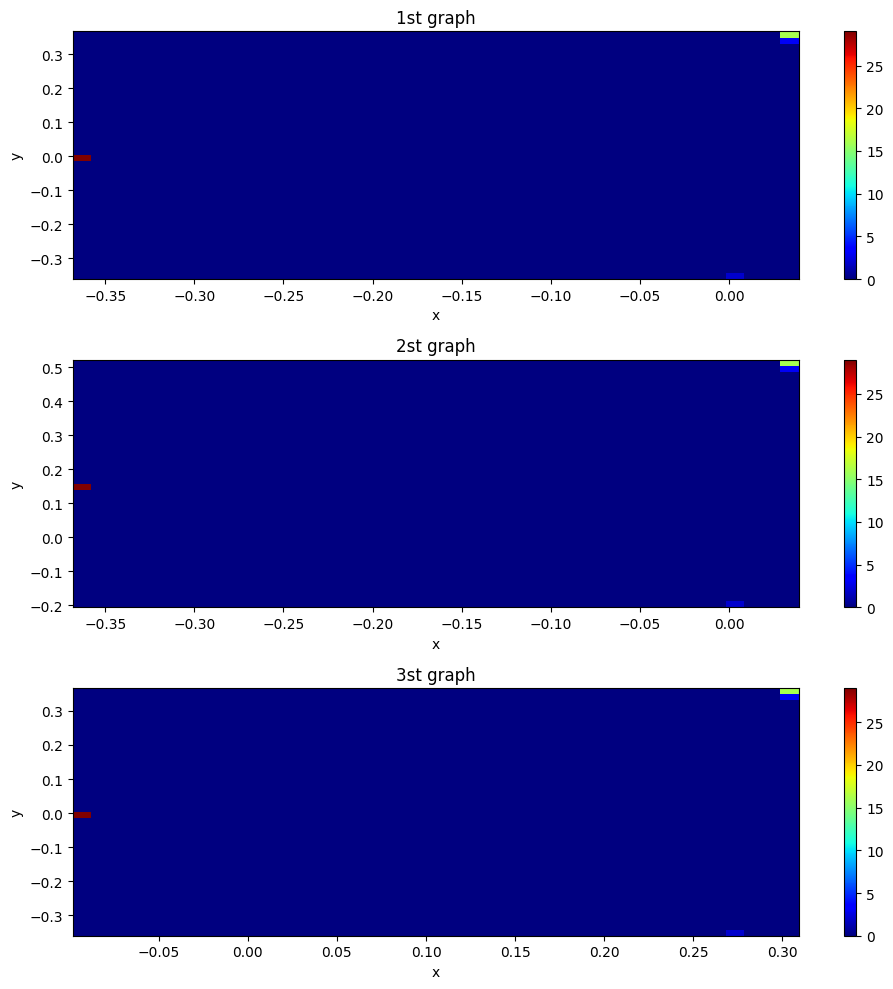

In [38]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(311)

H = ax.hist2d(Xs_collect[0,0,:],Xs_collect[0,1,:], bins=40, cmap=cm.jet)
ax.set_title('1st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)

ax = fig.add_subplot(312)

H = ax.hist2d(Xs_collect[1,0,:],Xs_collect[1,1,:], bins=40, cmap=cm.jet)
ax.set_title('2st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)

ax = fig.add_subplot(313)

H = ax.hist2d(Xs_collect[2,0,:],Xs_collect[2,1,:], bins=40, cmap=cm.jet)
ax.set_title('3st graph')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(H[3],ax=ax)
fig.tight_layout()
plt.show()

In [39]:
R.matrix.T@Xs[0],R.matrix.T@Xs[1],R.matrix.T@Xs[2],(b_collect*b_collect).sum(axis=0)[-1]

(array([ 0.03609726, -0.01358247, -0.36795439]),
 array([ 0.04631742,  0.00308163, -0.52171673]),
 array([ 0.26201603, -0.16142671, -0.36962427]),
 0.17120796610109767)

when wrong initialization
(array([-0.04128355,  0.16619236,  0.34825699]),
 array([-0.09665554,  0.04284078,  0.27247195]),
 array([0.16722164, 0.01833527, 0.43522747]))

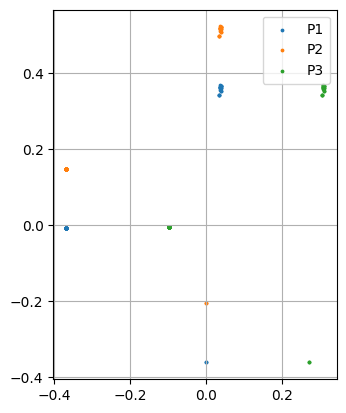

In [40]:
# illustrate the 3d points Xs on xy plane
plt.scatter(Xs_collect[0,0,:]     , Xs_collect[0,1,:],label='P1',s=3)
plt.scatter(Xs_collect[1,0,:], Xs_collect[1,1,:],label='P2',s=3)
plt.scatter(Xs_collect[2,0,:], Xs_collect[2,1,:],label='P3',s=3)
plt.grid()
# fix the aspect ration
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


In [32]:
# export collects in a csv format

df=pd.DataFrame(columns=['X1','Y1','Y2','X3','Y3','H','omega','phi','kappa']+[f'b{i+1}' for i in range(9)] +['det'])
df["X1"]=Xs_collect[0,0,:]
df["Y1"]=Xs_collect[0,1,:]
df["Y2"]=Xs_collect[1,1,:]
df["X3"]=Xs_collect[2,0,:]
df["Y3"]=Xs_collect[2,1,:]
df["H"]=Xs_collect[0,2,:]
df["omega"]=angle_collect[0,:]
df["phi"]=angle_collect[1,:]
df["kappa"]=angle_collect[2,:]
for i in range(9):
    df[f'b{i+1}']=b_collect[i,:]
df["det"]=det_collect
# add a column for the x increment
for i in range(9):
    df[f'dX{i+1}']=dXs_collect[i,:]

# add a column of the square error (b@b)
df["SE"]=(b_collect*b_collect).sum(axis=0)

#df.to_csv("output.csv")

In [33]:
df.to_csv("output.csv")

In [41]:
display(df)

,X1,Y1,Y2,X3,Y3,H,omega,phi,kappa,b1,...,dX1,dX2,dX3,dX4,dX5,dX6,dX7,dX8,dX9,SE
0,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,2.805705,0.714448,2.183325,6.715059e-17,...,-1.294561e-16,2.053189e-17,5.410718e-17,-9.300259e-19,9.197577e-18,8.349163e-17,-1.394795e-15,-6.784297e-17,1.583244e-15,4.105252e-31
1,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,-0.335888,2.427144,-0.958268,-0.000000e+00,...,-2.587067e-16,7.236527e-18,7.236527e-18,-5.310920e-17,7.236527e-18,1.045774e-16,-1.039456e-16,1.075576e-15,-3.489604e-16,1.387585e-30
2,0.038053,0.355203,0.510203,0.308052,0.355861,-0.095249,1.697197,-0.003767,2.561814,-4.476706e-17,...,-1.500254e-02,-7.363707e-02,-7.363707e-02,-1.500254e-02,-7.363707e-02,-4.331389e-01,9.549043e-01,-4.532377e-01,-1.772637e-02,1.626322e-01
3,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,2.805705,0.714448,2.183325,-4.476706e-17,...,-1.749851e-16,-4.086690e-17,-6.325043e-17,-4.654146e-17,-1.838834e-17,-2.688566e-16,1.751326e-15,-6.816653e-16,1.529612e-15,6.339259e-31
4,0.036314,0.354172,0.509172,0.306313,0.354830,-0.113715,-1.477268,3.128104,-0.585774,-4.476706e-17,...,-8.648831e-03,-9.597818e-02,-9.597818e-02,-8.648831e-03,-9.597818e-02,-4.177347e-01,1.013018e+00,5.042535e-01,-3.665039e-03,1.737141e-01
5,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,2.805705,0.714448,2.183325,1.790682e-16,...,-1.784331e-16,-1.842081e-19,8.934991e-17,-4.993374e-17,-5.643321e-19,-1.245441e-16,1.074297e-15,-1.455852e-16,-1.253339e-15,3.355168e-31
6,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,-0.335888,2.427144,-0.958268,-0.000000e+00,...,-2.615235e-16,7.585735e-18,7.585735e-18,-5.592606e-17,7.585735e-18,9.420262e-17,9.156381e-18,-1.751120e-15,-1.401842e-16,1.027987e-30
7,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,2.805705,0.714448,2.183325,6.715059e-17,...,-1.520843e-16,2.960477e-17,6.318006e-17,-2.355827e-17,1.827046e-17,1.237917e-16,-1.648365e-15,2.924059e-17,9.509681e-16,4.142567e-31
8,-0.368128,-0.006486,0.148514,-0.098129,-0.005828,-0.179360,-0.335888,2.427144,-0.958268,-1.119176e-16,...,2.162374e-16,1.209566e-16,6.499774e-17,3.636634e-17,1.100024e-16,-6.637902e-17,-5.456620e-16,1.220635e-15,1.264084e-16,5.704869e-31
9,0.038904,0.359463,0.514463,0.308903,0.360121,-0.061696,1.569755,0.077076,2.566005,-4.476706e-17,...,3.671180e-02,-5.165328e-02,-5.165328e-02,3.671180e-02,-5.165328e-02,-5.033560e-01,1.246322e+00,-8.225985e-01,4.065802e-02,2.295676e-01


In [35]:
for i,det in enumerate(det_collect):
    if det>0:
        print(i,det)

1 0.003810966741171295
4 0.016864764308316276
6 0.0038109667411712683
8 0.003810966741171302
10 0.016137236931355853
11 0.01686476430831623
14 0.003810966741171302
16 0.003810966741171302
18 0.017854355353469926
23 0.018381092915614794
25 0.017042578588348612
29 0.018711110872867948
31 0.01737975898954038
41 0.017589354352225084
42 0.0187111108728679
43 0.01758935435222507
45 0.0038109667411712882
47 0.003810966741171295
49 0.01871111087286794
